# 0. Install and Import Dependencies

In [246]:
!pip list

Package                      Version
---------------------------- ---------------
absl-py                      2.1.0
anyio                        4.2.0
argon2-cffi                  23.1.0
argon2-cffi-bindings         21.2.0
arrow                        1.3.0
asttokens                    2.4.1
astunparse                   1.6.3
async-lru                    2.0.4
attrs                        23.2.0
Babel                        2.14.0
beautifulsoup4               4.12.3
bleach                       6.1.0
cachetools                   5.3.2
certifi                      2024.2.2
cffi                         1.16.0
charset-normalizer           3.3.2
comm                         0.2.1
contourpy                    1.2.0
cycler                       0.12.1
debugpy                      1.8.1
decorator                    5.1.1
defusedxml                   0.7.1
exceptiongroup               1.2.0
executing                    2.0.1
fastjsonschema               2.19.1
filelock                     3.1

In [247]:
!pip install opencv-python matplotlib imageio gdown tensorflow

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

2024-02-22 20:16:43.398529: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-22 20:16:43.431406: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-22 20:16:43.431438: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-22 20:16:43.432411: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-22 20:16:43.437840: I tensorflow/core/platform/cpu_feature_guar

In [2]:

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)
tf.config.list_physical_devices('GPU')

2024-02-22 20:16:46.976041: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-22 20:16:47.004654: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-22 20:16:47.004825: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# 1. Build Data Loading Functions

In [251]:
import gdown

In [4]:
# url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
# output = 'data.zip'
# gdown.download(url, output, quiet=False)
# gdown.extractall('data.zip')
def generate_video_dict(path:str) -> dict[str:List[float]]: 
    video_dict= {}
    if not os.path.exists(path): 
        raise FileNotFoundError(f'{path} does not exist')
    for file in os.listdir(path): 
        if file.endswith('.mpg'): 
            cap = cv2.VideoCapture(os.path.join(path, file))
            frames = []
            for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):  
                ret, frame = cap.read()
                frame = tf.image.rgb_to_grayscale(frame)
                frames.append(frame[190:236,80:220,:])
            cap.release()
            mean = tf.math.reduce_mean(frames)
            std = tf.math.reduce_std(tf.cast(frames, tf.float16))
            video_dict[file] = tf.cast((frames - mean), tf.float16) / std
    return video_dict
cv2_base_dir = os.path.dirname(os.path.abspath(cv2.__file__))
haar_model = os.path.join(cv2_base_dir, 'data/haarcascade_frontalface_default.xml')

lip_cascade = cv2.CascadeClassifier(haar_model)

def generate_mounth_video_dict(path:str) -> dict[str:List[float]]:
    video_dict= {}
    if not os.path.exists(path):
        raise FileNotFoundError(f'{path} does not exist')
    for file in os.listdir(path):
        if file.endswith('.mpg'):
            cap = cv2.VideoCapture(os.path.join(path, file))
            frames = []
            for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
                ret, frame = cap.read()
                # frame = tf.image.rgb_to_grayscale(frame)
                gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                lips = lip_cascade.detectMultiScale(gray_frame, 1.1, 4)
                for (x, y, w, h) in lips:
                    frame = gray_frame[y:y + h, x:x + w]
                    frame = tf.image.resize(frame, [46, 140, 1])
                frames.append(frame)

                frames.append(frame)
            cap.release()
            mean = tf.math.reduce_mean(frames)
            std = tf.math.reduce_std(tf.cast(frames, tf.float16))
            video_dict[file] = tf.cast((frames - mean), tf.float16) / std
    return video_dict
def load_video(path:str) -> List[float]:

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()  # close the video file

    mean = tf.math.reduce_mean(frames)  # compute the mean
    std = tf.math.reduce_std(tf.cast(frames, tf.float32)) # compute the standard deviation
    return tf.cast((frames - mean), tf.float32) / std # normalize to zero mean and unit variance
video_dict=None

In [5]:
import sys

video_dict = generate_video_dict('./data/s10')
print(len(video_dict))
# print memory in video_dict
dict_size = sys.getsizeof(video_dict)
print(f"Size of video_dict: {dict_size} bytes")
    

2024-02-22 20:16:57.877849: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-22 20:16:57.878117: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-22 20:16:57.878267: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

1000
Size of video_dict: 36960 bytes


In [28]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz "]

NameError: name 'video_dict' is not defined

In [6]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

In [7]:
char_to_num.get_vocabulary()

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ' '] (size =28)


In [8]:
char_to_num(['n','i','c','k'])

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 ' ']

In [9]:
num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11])>

In [10]:
# def load_alignments(path:str) -> List[str]: 
#     with open(path, 'r') as f: 
#         lines = f.readlines() 
#     tokens = []
#     for line in lines:
#         line = line.split()
#         if line[2] != 'sil': 
#             tokens = [*tokens,' ',line[2]]
#     return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]
def init_alignments(path:str) -> dict[str:List[str]]: 
    alignments = {}
    if not os.path.exists(path): 
        raise FileNotFoundError(f'{path} does not exist')
    for file in os.listdir(path): 
        if file.endswith('.align'): 
            with open(os.path.join(path, file), 'r') as f: 
                lines = f.readlines()
            tokens = []
            for line in lines:
                line = line.split()
                if line[2] != 'sil': 
                    tokens = [*tokens,' ',line[2]]
            alignments[file] = char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]
    return alignments
alignments_dict = init_alignments('./data/alignments/s1')


<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [11]:
print(len(alignments_dict))

In [12]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    # file_name = path.split('\\')[-1].split('.')[0]
    video_path = f'{file_name}.mpg'
    alignment_path = f'{file_name}.align'
    frames = video_dict.get(video_path)
    alignments = alignments_dict.get(alignment_path)
    
    return frames, alignments

1000


In [13]:
test_path = './data/s1/bbal6n.mpg'

In [14]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0] 

In [15]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

'bbal6n'

In [16]:
print(len(frames))

In [17]:
plt.imshow(frames[40])


75


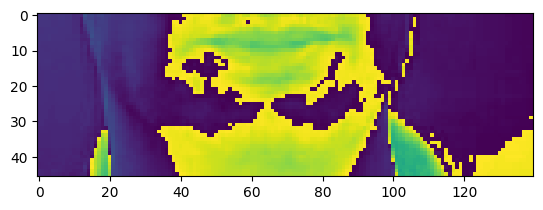

In [18]:
alignments

In [19]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 27,  2, 12, 21,  5, 27,  1, 20, 27, 12, 27, 19,  9, 24,
       27, 14, 15, 23])>

In [20]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float16, tf.int64)) # py_function is used to convert a python function to a tensorflow function
    return result

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

# 2. Create Data Pipeline

In [ ]:
from matplotlib import pyplot as plt

In [22]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')  # list all the files
data = data.shuffle(500, reshuffle_each_iteration=False)   # shuffle is used to shuffle the data
data = data.map(mappable_function) # 75 frames, 46x140 pixels, 1 channel
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40])) # 75 frames, 46x140 pixels, 1 channel
data = data.prefetch(tf.data.AUTOTUNE) # prefetch the data
# Added for split 
train = data.take(450) 
test = data.skip(450)

In [23]:
print(len(data))
print(len(train))
print(len(test))

In [24]:
frames, alignments = data.as_numpy_iterator().next()

500
450
50


In [25]:
len(frames)

In [26]:
sample = data.as_numpy_iterator()

2

In [27]:
val = sample.next(); val[0]

In [28]:
# imageio.mimsave('./animation.gif', val[0][0], fps=10) # can't handle this data type:(1,1,1), <f4
# imageio.mimsave('./animation.gif', val[0][0].astype(np.uint8), fps=10)


array([[[[[ 1.483  ],
          [ 1.483  ],
          [ 1.442  ],
          ...,
          [ 0.12366],
          [ 0.12366],
          [ 0.12366]],

         [[ 1.483  ],
          [ 1.483  ],
          [ 1.442  ],
          ...,
          [ 0.12366],
          [ 0.12366],
          [ 0.12366]],

         [[ 1.524  ],
          [ 1.524  ],
          [ 1.483  ],
          ...,
          [ 0.12366],
          [ 0.12366],
          [ 0.12366]],

         ...,

         [[ 0.9893 ],
          [ 0.9893 ],
          [ 0.9893 ],
          ...,
          [10.305  ],
          [10.305  ],
          [10.305  ]],

         [[ 0.865  ],
          [ 0.865  ],
          [ 0.7417 ],
          ...,
          [10.305  ],
          [10.305  ],
          [10.305  ]],

         [[ 0.7417 ],
          [ 0.7007 ],
          [ 0.659  ],
          ...,
          [10.305  ],
          [10.305  ],
          [10.305  ]]],


        [[[ 1.442  ],
          [ 1.442  ],
          [ 1.483  ],
          ...,
        

In [29]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video 
plt.imshow(val[0][0][35])

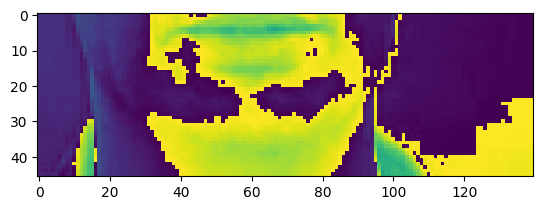

In [30]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

# 3. Design the Deep Neural Network

In [ ]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.applications import ResNet50

In [32]:
data.as_numpy_iterator().next()[0][0].shape

In [33]:
base_model = ResNet50(weights=None, include_top=False, input_shape=(46,140, 3))

# If you wish to Freeze layers
for layer in base_model.layers:
  layer.trainable = True
  
model = Sequential()
model.add(base_model)
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))  # 128 filters, 3x3 kernel input shape is 75 frames, 46x140 pixels, 1 channel 
model.add(Activation('relu'))  # activation function
model.add(MaxPool3D((1,2,2)))  # max pooling

model.add(Conv3D(256, 3, padding='same'))  # 256 filters, 3x3 kernel
model.add(Activation('relu'))  
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))  # flatten the output of the previous layer

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))  # bidirectional LSTM
model.add(Dropout(.5))  # dropout layer

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))  # output layer

(75, 46, 140, 1)

In [34]:
model.summary()

In [35]:
5*17*75

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                      

In [52]:
yhat = model.predict(val[0])

(2, 75, 46, 140, 1)

In [36]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

2024-02-22 20:19:18.630819: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-02-22 20:19:18.714614: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 4s 4s/step


In [37]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'ccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc'>

In [38]:
model.input_shape

<tf.Tensor: shape=(), dtype=string, numpy=b'ccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc'>

In [39]:
model.output_shape

(None, 75, 46, 140, 1)

# 4. Setup Training Options and Train

In [ ]:
def scheduler(epoch, lr):   # learning rate scheduler
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)  

In [41]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [42]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        try:
            data = self.dataset.next()
            yhat = self.model.predict(data[0])
            decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
            for x in range(len(yhat)):           
                print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
                print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
                print('~'*100)
        except StopIteration:
            self.dataset = self.dataset.as_numpy_iterator()
            data = self.dataset.next()
            yhat = self.model.predict(data[0])
            decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
            for x in range(len(yhat)):           
                print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
                print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
                print('~'*100)

In [43]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [44]:
checkpoint_callback = ModelCheckpoint(os.path.join('models_4','checkpoint'), monitor='loss', save_weights_only=True) 

In [46]:
schedule_callback = LearningRateScheduler(scheduler)

In [47]:
example_callback = ProduceExample(train)

In [48]:
model.fit(train, validation_data=test, epochs=60, callbacks=[checkpoint_callback, schedule_callback],batch_size=400)

# caculate the loss

In [105]:
# model.evaluate(test)
loss_history = model.history.history

Epoch 1/60


2024-02-18 12:03:27.076344: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fe6cc1aae50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-18 12:03:27.076358: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2024-02-18 12:03:27.084683: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1708257807.142641    4736 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


450/450 [==============================] - 91s 179ms/step - loss: 83.8198 - val_loss: 71.2452 - lr: 1.0000e-04
Epoch 2/60
450/450 [==============================] - 80s 177ms/step - loss: 72.2615 - val_loss: 67.7371 - lr: 1.0000e-04
Epoch 3/60
450/450 [==============================] - 80s 177ms/step - loss: 69.1459 - val_loss: 63.1106 - lr: 1.0000e-04
Epoch 4/60
450/450 [==============================] - 80s 177ms/step - loss: 66.6024 - val_loss: 61.7896 - lr: 1.0000e-04
Epoch 5/60
450/450 [==============================] - 80s 177ms/step - loss: 64.2782 - val_loss: 61.3682 - lr: 1.0000e-04
Epoch 6/60
450/450 [==============================] - 80s 177ms/step - loss: 63.0311 - val_loss: 60.7375 - lr: 1.0000e-04
Epoch 7/60
450/450 [==============================] - 80s 177ms/step - loss: 61.9308 - val_loss: 58.4117 - lr: 1.0000e-04
Epoch 8/60
450/450 [==============================] - 80s 177ms/step - loss: 60.9039 - val_loss: 58.3614 - lr: 1.0000e-04
Epoch 9/60
450/450 [===============

In [106]:
# draw the loss curve
print(loss_history.keys())
plt.plot(loss_history['loss'], label='loss')
plt.plot(loss_history['val_loss'], label='val_loss')
# x label and y label
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve for adding resNet50')
plt.legend(loc='upper right')
# filename = 'loss_curve_resNet50.png'
# plt.savefig(filename)      
plt.show()


# 5. Make a Prediction 

In [ ]:
# url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
# output = 'checkpoints.zip'
# gdown.download(url, output, quiet=False)
# gdown.extractall('checkpoints.zip', 'models')

In [ ]:
model.load_weights('models_4/checkpoint')


In [53]:
## test on the test data
test_loss= model.evaluate(test)
print(f' adding resNet50 The Test loss: {test_loss}')
# accuracy
accuracy = 100 - test_loss
print(f' adding resNet50 The Test accuracy: {accuracy}')
# test on the train data
train_loss= model.evaluate(train)
print(f' adding resNet50 The Train loss: {train_loss}')


In [51]:
test_data = test.as_numpy_iterator()

50/50 [==============================] - 4s 54ms/step - loss: 103.2302
 adding resNet50 for dataset S10 The Test loss: 103.23021697998047
 adding resNet50 for dataset S10 The Test accuracy: -3.2302169799804688
450/450 [==============================] - 24s 54ms/step - loss: 101.0674
 adding resNet50 for dataset S10 The Train loss: 101.0674057006836


In [152]:
sample = test_data.next()

In [153]:
yhat = model.predict(sample[0])

In [154]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

1/1 [==============================] - 1s 593ms/step


In [155]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin green at t nine soon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin blue in z one soon'>]

In [156]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

# Test on a Video

In [ ]:
sample = load_data(tf.convert_to_tensor('./data/s1/bbal6n.mpg'))

In [158]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

In [159]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>]

In [160]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

1/1 [==============================] - 1s 610ms/step


In [161]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>]